In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import time
import math
import os
import sys
import random
from functools import partial
from decimal import Decimal
import numpy as np
import scipy.io as sio
import pysindy as ps
from tqdm import trange

sys.path.insert(0, '../')
from utils import *
from solvel0 import solvel0, MIOSR
from best_subset import backward_refinement, brute_force_all_subsets, brute_force
from UBIC import *
from bayesian_model_evidence import log_evidence

from skimage.restoration import estimate_sigma
import bm3d
from kneed import KneeLocator

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn import covariance
from sklearn.linear_model import lars_path
from abess import LinearRegression as AbessLinearRegression
from knockpy import KnockoffFilter, knockoff_stats, knockoffs
from knockpy.utilities import estimate_covariance
from scipy import stats
from statsmodels.stats.multitest import multipletests
from c2st.check import c2st # https://github.com/psteinb/c2st

from mbic import mbic, mbic2, ebic

from rdata import read_rds
from selective_inference import forward_stop_rule, sfs_si, stepwise_selective_inference, subset_fdr
import fpsample
from dppy.finite_dpps import FiniteDPP

from si4pipeline import (
                        construct_pipelines, 
                        extract_features, 
                        initialize_dataset, 
                        intersection, 
                        lasso, 
                        marginal_screening, 
                        stepwise_feature_selection, 
                        union, 
                        PipelineManager
                        )

from compromise_programming import compromise_programming

alibi is not installed in the environment.


In [2]:
data_path = "../Datasets/"
data = sio.loadmat(os.path.join(data_path, "burgers.mat"))
u_clean = (data['usol']).real; u = u_clean.copy()
x = (data['x'][0]).real
t = (data['t'][:,0]).real
xt = np.array([x, t], dtype=object)
dt = t[1]-t[0]; dx = x[2]-x[1]

In [3]:
np.random.seed(0)
noise_type = "gaussian"
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


In [4]:
np.random.seed(0)
fake_noise = np.random.normal(loc=0.0, scale=estimate_sigma(u), size=u.shape)
sigmas = estimate_sigma(u+fake_noise)*np.arange(0.1, 2., 0.1)
est_sigma = sigmas[np.argmin([((u-bm3d.bm3d(u+fake_noise, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES, blockmatches=(False, False)))**2).mean() \
                              for sigma in sigmas])]
u = bm3d.bm3d(u, sigma_psd=est_sigma, 
                  stage_arg=bm3d.BM3DStages.ALL_STAGES, 
                  blockmatches=(False, False))

### weakident

In [5]:
# from weakident_python.weakindent_model import weak_ident

# # Ground truth
# true_coefficients = np.array([np.array([[2, 1, 0, -0.5], [1, 2, 0, 0.1]])])
# # Hyperparameters
# config = {'true_coefficients': true_coefficients, 
#           'max_dx': 6, 'max_poly': 6, 'use_cross_der': False, 'skip_x': 7, 'skip_t': 3, 'tau': 0.05}

# # Sparse regression
# np.random.seed(99)
# X_pre, y_pre, c_pred, dictionary_list, lhs_feature, rhs_feature = weak_ident(np.expand_dims(u, 0), xt, **config)
# feature_names = rhs_feature

### ps.WeakPDELibrary

In [6]:
n_poly = 6
n_derivatives = 6
n_weak = 2000

### Cache (n_weak = 10000) ###
# X_pre = np.load("../Cache/X_pre_burgers_noise50.npy")
# y_pre = np.load("../Cache/y_pre_burgers_noise50.npy")
# u_pre = y_pre.copy()
# feature_names = np.load("../Cache/feature_names_burgers.npy")
# fsInf = read_rds("../R/R_data/fsInf_screening_burgers_noise50.rds")

function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=np.asarray([*np.meshgrid(x, t)]).T,
    include_bias=True,
    diff_kwargs={"is_uniform":True},
    K=n_weak
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))
feature_names = np.array(weak_lib.get_feature_names())

### Knockoffs

In [7]:
from hidimstat import (model_x_knockoff, 
                    model_x_knockoff_pvalue, 
                    model_x_knockoff_bootstrap_quantile, 
                    model_x_knockoff_bootstrap_e_value)

# selected, test_scores, threshold, X_tildes = model_x_knockoff(X_pre, 
#                                                               y_pre, 
#                                                               centered=True, 
#                                                               n_bootstraps=25, 
#                                                               fdr=0.1, 
#                                                               n_jobs=-1)

from sklearn.utils import resample
from abess import LinearRegression as AbessLinearRegression
from knockpy import KnockoffFilter, knockoff_stats, knockoffs
from knockpy.utilities import estimate_covariance
from scipy import stats
from statsmodels.stats.multitest import multipletests
from c2st.check import c2st # https://github.com/psteinb/c2st

u_pre = y_pre.copy()
X_pre_top = StandardScaler().fit_transform(X_pre)
y_pre = StandardScaler().fit_transform(u_pre)

lr = AbessLinearRegression(path_type='gs', s_max=10, fit_intercept=False, cv=5, screening_size=0)

kfilter = KnockoffFilter(ksampler='gaussian', fstat=knockoff_stats.ShapStatistic(model=lr), 
                         knockoff_kwargs={'method':'ci'})
# kfilter = KnockoffFilter(ksampler='gaussian', fstat=knockoff_stats.FeatureStatistic(model=lr), 
#                          knockoff_kwargs={'method':'ci'}, fstat_kwargs={'feature_importance':'swapint'})
# kfilter = KnockoffFilter(ksampler='gaussian', fstat='lasso', knockoff_kwargs={'method':'ci'})

In [8]:
fdr = 1/3 # 1/4, 1/3, 1/2
rejections = []
test_scores = []
thresholds = []
for _ in trange(50):
    np.random.seed(_)
    # X_resample, y_resample = resample(X_pre_top, y_pre.flatten(), replace=True, random_state=_)
    rejection = kfilter.forward(X=X_pre_top, y=y_pre.flatten(), fdr=fdr, shrinkage="ledoitwolf", recycle_up_to=0.5)
    rejection = sorted(set(np.where(rejection == 1)[0]))
    if len(rejection) > 0:
        rejections.append(rejection)
        test_scores.append(kfilter.W)
        thresholds.append(kfilter.threshold)
# del X_resample, y_resample

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]


In [9]:
aggregated_ko_selection, _, _ = model_x_knockoff_bootstrap_quantile(test_scores, 
                                                                    fdr=fdr, 
                                                                    adaptive_aggregation=False)
print(feature_names[aggregated_ko_selection])

# TODO: Calculate 1-FDR
# ShapStatistic: ['x0_11' 'x0_1111' 'x0x0_1' 'x0^6x0_1']
# swap: ['x0_11' 'x0_1111' 'x0x0_1' 'x0^6x0_1']
# swapint: ['x0_11' 'x0_1111' 'x0x0_1' 'x0^6x0_1']
eval_selection = []
while True:
    eval_selection, _, _ = model_x_knockoff_bootstrap_e_value(test_scores, thresholds, fdr=fdr)
    print(feature_names[eval_selection])
    if len(eval_selection) > 0:
        break
    else:
        fdr += 0.01

[]
['x0_11' 'x0_1111' 'x0x0_1' 'x0^6x0_1']


In [10]:
rejections = np.array(eval_selection)
X_pre_top = X_pre_top[:, rejections]
feature_names[rejections]

array(['x0_11', 'x0_1111', 'x0x0_1', 'x0^6x0_1'], dtype='<U13')

In [11]:
alpha = 0.05
classifer_threshold = 0.5
while True:
    non_null_indices, shap_values = shap_model_selection(X_pre_top, y_pre)
    rejections = rejections[non_null_indices]
    X_pre_top = X_pre_top[:, non_null_indices]
    print(abs(shap_values).mean(axis=0))
    print(feature_names[rejections])

    decision = True
    Sigma, invSigma = estimate_covariance(X_pre_top, 1e-3, "graphicallasso") # graphicallasso, ledoitwolf
    for j in range(len(rejections)-1, -1, -1):
        classifier_confidences = []
        for _ in trange(50):
            Xk = knockoffs.GaussianSampler(X_pre_top, Sigma=Sigma, invSigma=invSigma, 
                                           method='ci').sample_knockoffs()
            Xn = X_pre_top.copy()
            Xn[:, j] = Xk[:, j]
            
            swap_explainer = shap.explainers.Linear(linear_model.LinearRegression(fit_intercept=False).fit(Xn, y_pre),
                                                    Xn)
            swap_shap_values = swap_explainer(Xn).values
            
            classifier_confidences.append(c2st(shap_values[:, j:j+1], swap_shap_values[:, j:j+1], clf=linear_model.LogisticRegression(fit_intercept=True)))
    
        classifier_confidences = np.array(classifier_confidences)
        pv = stats.wilcoxon(classifier_confidences-classifer_threshold, alternative='greater').pvalue
        
        print("binary classifier's acc:", classifier_confidences.mean())
        print("P-value:", pv)
    
        if not pv < alpha:
            decision = False
            break

    if not decision:
        # non_null_indices = list(solvel0(X_pre_top, y_pre, max_complexity=len(rejections)-1, miosr=True, refine=True)[-1])
        non_null_indices = np.nonzero(brute_force(X_pre_top, y_pre, support_size=len(rejections)-1))[0]
        rejections = rejections[non_null_indices]
        X_pre_top = X_pre_top[:, non_null_indices]
    else:
        break

# Optional
nonzero_miosr = np.array([], dtype=np.int32)
for _ in range(len(rejections)):
    nonzero_miosr = np.union1d(nonzero_miosr, np.nonzero(brute_force(X_pre, y_pre, len(rejections)-_))[0])
rejections = np.intersect1d(rejections, nonzero_miosr)
feature_names[rejections]

[0.42595638 0.23988648 0.0765915  0.02027287]
['x0x0_1' 'x0_11' 'x0_1111' 'x0^6x0_1']


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.34it/s]


binary classifier's acc: 0.5012415625753097
P-value: 0.8458892795742642
[0.3958972  0.24665996 0.07334003]
['x0x0_1' 'x0_11' 'x0_1111']


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.79it/s]


binary classifier's acc: 0.5550766948965006
P-value: 8.881784197001252e-16


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.53it/s]


binary classifier's acc: 0.5226311928742589
P-value: 3.6855262497673027e-10


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.79it/s]


binary classifier's acc: 0.5723875069446387
P-value: 3.703108808858409e-10


array(['x0_11', 'x0_1111', 'x0x0_1'], dtype='<U13')

In [12]:
X_pre_top = X_pre[:, rejections]
X_pre_top = X_pre_top/np.linalg.norm(X_pre_top, 2, axis=0)
y_pre = u_pre.copy()

In [13]:
best_subsets = brute_force_all_subsets(X_pre_top, y_pre)[1]

100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 4739.33it/s]


### Compromise programming

In [14]:
compromise_programming(best_subsets, (X_pre_top, y_pre), criterion="bic")

[[-1.54696627e+04  1.00000000e+00]
 [-1.79960192e+04  2.00000000e+00]
 [-1.83368044e+04  3.00000000e+00]] [(1, 4)]


(array([[0.05101649, 1.        ],
        [0.01437039, 2.        ],
        [0.01207307, 3.        ]]),
 [[(1, 4)]],
 [[array([0.282653  , 0.79691737, 0.717347  ]),
   array([-0.24070054,  0.25005691,  0.19399345]),
   array([0.25      , 0.78585586, 0.75      ]),
   array([0.717347  , 0.22658954, 0.282653  ])]])

In [15]:
compromise_programming(best_subsets, (X_pre_top, y_pre), criterion="bme")

[[-3.38137046e+03  1.00000000e+00]
 [-3.39031138e+03  2.00000000e+00]
 [-3.39073584e+03  3.00000000e+00]] [(1, 4)]


(array([[0.05101649, 1.        ],
        [0.01437039, 2.        ],
        [0.01207307, 3.        ]]),
 [[(1, 4)]],
 [[array([0.282653  , 0.82823548, 0.717347  ]),
   array([-0.25505317,  0.28845541,  0.17964083]),
   array([0.25      , 0.84100816, 0.75      ]),
   array([0.717347  , 0.17383842, 0.282653  ])]])

### UBIC

In [16]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75 # 80

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre_top, y_pre), 
                                               u_type='cv1', take_sqrt=True, 
                                               ridge_lambda=0, 
                                               threshold=0)
# b_uns = ard_uns # USE ard_uns INSTEAD
predictions = X_pre_top@post_means
print(b_bics)
print(b_uns)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    # None / Round / Ceil / Floor: Decided by researchers to automate the model selection process
    thres = np.round(sci_format(thres)[0])*10**sci_format(thres)[1]
except IndexError:
    thres = 1/40
min_thres = 1/40
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    if last_bc not in bc_seq:
        bc_seq.append(last_bc)

# best_bc = knee(range(len(last_ubic)), last_ubic, 0.95, 'linear', direction='decreasing')
best_bc = knee_finder(last_ubic)
if best_bc == 0 and last_bc != 0 and b_bics[last_bc] < b_bics[0] and \
                                    abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
    best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 0.95, 'linear')
if best_bc is None:
    best_bc = knee_finder(last_ubic)
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-15469.662713973235, -17996.01922601443, -18336.80438996851]
[1.47189787 1.         1.37366719]
threshold: 0.1
max_lam: 3.374311289094506
1 <---> 1 inf
1 <---> 2 0.018936697036945532


(2.24954086, array([-13482.26998279, -16645.79461807, -16482.04514318]), 1, 1)

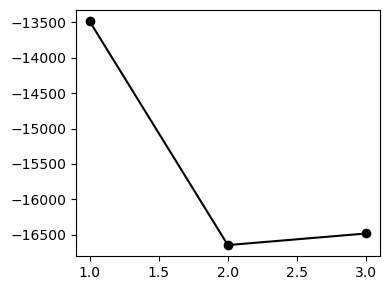

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot([len(bs) for bs in best_subsets], last_ubic, '-o', c='black')
plt.show()

### Selective inference

In [18]:
# Assume that mbics is a decreasing sequence
complexities = np.array([len(_) for _ in best_subsets])

if len(best_subsets) <= 2:
    knee = complexities.max()
else:
    ebics = []
    mbics = []
    for _ in best_subsets:
        loglik = log_like_value(X_pre_top[:, _]@np.linalg.lstsq(X_pre_top[:, _], y_pre, rcond=None)[0], 
                                y_pre)
        ebics.append(ebic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=0))
        mbics.append(mbic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=2))
    ebics = np.array(ebics)
    mbics = np.array(mbics)

    if np.alltrue(np.array(mbics) >= np.array([max(mbics)+_*(min(mbics)-max(mbics))/(np.argmin(mbics)-np.argmax(mbics)) for _ in range(len(best_subsets))])):
        knee = complexities.max()
    else:    
        decreasing_indices = np.array(mbics) <= np.array([max(mbics)+_*(min(mbics)-max(mbics))/(np.argmin(mbics)-np.argmax(mbics)) for _ in range(len(best_subsets))])
        knee = knee_finder(mbics[decreasing_indices])
        knee = (complexities[decreasing_indices])[knee]
    
knee

2

In [19]:
np.random.seed(0); random.seed(0)
n_samples = min(int(250*knee), len(y_pre))
false_discovery_control_method = None
fdr_data = []
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        DPP.flush_samples()
        for _ in range(n_samples//(len(bs))):
            DPP.sample_exact_k_dpp(size=len(bs))
        sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    if fdrs.mean() < 1:
        print(len(bs), fdrs.mean())
        fdr_data.append(fdrs)
        
fdr_data = np.array(fdr_data)

1 0.0
2 5.963068928024562e-11
3 0.042362883678236964


In [20]:
from sklearn.cluster import AffinityPropagation, KMeans
print(AffinityPropagation().fit(fdr_data).labels_)
print(KMeans(n_clusters=2).fit(fdr_data).labels_)

[0 0 1]
[0 0 1]


In [21]:
np.random.seed(0); random.seed(0)
n_samples = min(int(250*knee), len(y_pre))
false_discovery_control_method = 'by'
fdr_data = []
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        DPP.flush_samples()
        for _ in range(n_samples//(len(bs))):
            DPP.sample_exact_k_dpp(size=len(bs))
        sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    if fdrs.mean() < 1:
        print(len(bs), fdrs.mean())
        fdr_data.append(fdrs)
        
fdr_data = np.array(fdr_data)

1 0.0
2 8.94460339240921e-11
3 0.08233111956645527


### Selective inference (with estimated FDR) ###

### Python

In [7]:
n_terms = 16
max_complexity = 10
alphas = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]

### OPTION-I ###
_, lars_p, _ = lars_path(StandardScaler().fit_transform(X_pre), y_pre.flatten(), method='lasso', alpha_min=1e-6, max_iter=1000)
lars_p = np.array(list(map(int, lars_p)))[:n_terms]

### OPTION-II ###
# nonzero = np.nonzero(AbessLinearRegression(s_min=1, s_max=n_terms, path_type='gs', fit_intercept=False, alpha=1e-9, max_iter=100).fit(X_pre, y_pre.flatten()).coef_)[0]
# nonzero = np.nonzero(MIOSR(X_pre, y_pre, alpha=1e-9, non_zero=min(len(nonzero), n_terms)))[0]
# _, lars_p, _ = lars_path(StandardScaler().fit_transform(X_pre[:, nonzero]), y_pre.flatten(), method='lasso', alpha_min=0)
# lars_p = nonzero[np.array(list(map(int, lars_p)))][:n_terms]

X_test = X_pre[:, lars_p]
sigma = np.std(y_pre-X_test@np.linalg.lstsq(X_test, y_pre)[0], ddof=1)
manager = stepwise_selective_inference(support_size=len(lars_p))
_, p_list = manager.inference(X_test, y_pre, sigma)
print(lars_p, p_list, subset_fdr(p_list))

for alpha in alphas:
    adjusted_pvalues = p_list
    stop_step, false_discovery_rates = forward_stop_rule(adjusted_pvalues, alpha)
    adjusted_pvalues = adjusted_pvalues[:stop_step+1]
    rejections = np.sort(lars_p[:stop_step+1])
    if len(rejections) <= max_complexity: 
        break
max_fdr = alpha
max_fdr, feature_names[rejections], len(rejections)

[13  8 31 10  0 44 19  9 16 12 48  6 11 35 32 39] [0.0, 0.0, 0.07857371647513556, 2.5975666062549863e-11, 0.0897928287576325, 0.0, 1.6850402052570601e-06, 1.077635758406359e-09, 0.0, 0.16881660353373795, 0.0, 0.1386174966412872, 3.544258979903958e-05, 0.0, 0.0, 0.0] 0.03187963178091451


(0.01, array(['x0_11', 'x0x0_1'], dtype='<U13'), 2)

### R

In [8]:
# max_complexity = 10
# alphas = [0.3, 0.2, 0.1, 0.05, 0.01]
# for alpha in alphas:
#     adjusted_pvalues = fsInf.get("pv")
#     stop_step, false_discovery_rates = forward_stop_rule(adjusted_pvalues, alpha)
#     adjusted_pvalues = adjusted_pvalues[:stop_step+1]
#     rejections = np.sort((fsInf.get("vars")-1).astype(np.int32)[:stop_step+1])
#     if len(rejections) <= max_complexity:
#         break
# max_fdr = alpha
# feature_names[rejections]

In [9]:
X_pre_top = X_pre[:, rejections]
X_pre_top = X_pre_top/np.linalg.norm(X_pre_top, 2, axis=0)

In [10]:
_, best_subsets = brute_force_all_subsets(X_pre_top, y_pre, max_support_size=8)

100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 4148.67it/s]


In [11]:
# Assume that mbics is a decreasing sequence
complexities = np.array([len(_) for _ in best_subsets])

if len(best_subsets) <= 2:
    knee = complexities.max()
else:
    ebics = []
    mbics = []
    for _ in best_subsets:
        loglik = log_like_value(X_pre_top[:, _]@np.linalg.lstsq(X_pre_top[:, _], y_pre, rcond=None)[0], 
                                y_pre)
        ebics.append(ebic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=0))
        mbics.append(mbic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=2))
    ebics = np.array(ebics)
    mbics = np.array(mbics)

    if np.alltrue(np.array(mbics) >= np.array([max(mbics)+_*(min(mbics)-max(mbics))/(np.argmin(mbics)-np.argmax(mbics)) for _ in range(len(best_subsets))])):
        knee = complexities.max()
    else:    
        decreasing_indices = np.array(mbics) <= np.array([max(mbics)+_*(min(mbics)-max(mbics))/(np.argmin(mbics)-np.argmax(mbics)) for _ in range(len(best_subsets))])
        knee = knee_finder(mbics[decreasing_indices])
        knee = (complexities[decreasing_indices])[knee]
    
knee

2

In [12]:
np.random.seed(0); random.seed(0)
n_samples = min(int(250*knee), len(y_pre))
false_discovery_control_method = 'bh'
print("max fdr:", max_fdr)
fdr_data = []
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        DPP.flush_samples()
        for _ in range(n_samples//(len(bs))):
            DPP.sample_exact_k_dpp(size=len(bs))
        sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        # print(M, p_list, np.array(p_list) < 0.05)
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    if fdrs.mean() < 1:
        print(len(bs), fdrs.mean(), stats.wilcoxon(fdrs-max_fdr, alternative='less').pvalue)
        fdr_data.append(fdrs)
        
fdr_data = np.array(fdr_data)

max fdr: 0.01
1 0.0 0.0625
2 5.963064764688218e-11 0.0625


In [13]:
from sklearn.cluster import AffinityPropagation, KMeans
print(AffinityPropagation().fit(fdr_data).labels_)
print(KMeans(n_clusters=2).fit(fdr_data).labels_)
# plt.plot([1, 2, 3, 4], fdr_data.mean(axis=-1), 'o'); plt.show()

[0 1]
[1 0]


In [14]:
np.random.seed(0); random.seed(0)
n_samples = min(int(250*knee), len(X_pre))
false_discovery_control_method = 'bh'
print("max fdr:", max_fdr)
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        # DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        # DPP.flush_samples()
        # for _ in range(n_samples//(len(bs))):
        #     DPP.sample_exact_k_dpp(size=len(bs))
        # sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        # X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        # print(M, p_list, np.array(p_list) < 0.05)
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    print(fdrs.mean(), stats.wilcoxon(fdrs-max_fdr, alternative='less').pvalue)

max fdr: 0.01
0.0 0.0625
0.0 0.0625
